<a href="https://colab.research.google.com/github/ManuSinghYadav/Image-Clustering/blob/main/Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data Loading

Dataset of images can be downloaded from [here](https://www.kaggle.com/datasets/heavensky/image-dataset-for-unsupervised-clustering).

We created a folder called "Images" and inside that we uploaded all the images.

###Feature Extraction by VGG16

In [141]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

In [142]:
model = VGG16(weights='imagenet', include_top=False, pooling='max')

In [143]:
import os

file_list = os.listdir('/content/Images')
img_name = []
flattened_features = []

for i in file_list:
  if i=='.ipynb_checkpoints':
    continue
  else:
    a = '/content/Images/{}'.format(i)
    img = image.load_img(a, target_size = (224, 224))
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = model.predict(img)
    img_name.append(i)
    flattened_features.append(features.flatten())

1/1 [==============================] - 0s 484ms/step


###Preprocessing of the extracted features

####Feature Scaling (Standardization)

In [144]:
from sklearn.preprocessing import StandardScaler

features_scaled = StandardScaler().fit_transform(flattened_features)

####Feature Selection (PCA)

In [145]:
features_scaled.shape

(80, 512)

In [146]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 100).fit(features_scaled)

In [147]:
cumulative_explainable_ratio = 0.95
n_components = 0
cum_variance_explained_ratio = 0

while cum_variance_explained_ratio < cumulative_explainable_ratio:
  cum_variance_explained_ratio += pca.explained_variance_ratio_[n_components]
  n_components = n_components + 1

print("Will keep {} dimensions to achieve cumulative explainable ratio of {}".format(n_components, str(int(cumulative_explainable_ratio * 100))+"%"))

Will keep 63 dimensions to achieve cumulative explainable ratio of 95%


In [148]:
features_selected = PCA(n_components = n_components, random_state = 100).fit_transform(features_scaled)

In [149]:
features_selected.shape

(80, 63)

###Clustering

In [150]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

####Calculating WCSS for determining optimal number of clusters.

In [151]:
wcss = []
for i in range(1, 80):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(features_selected)
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

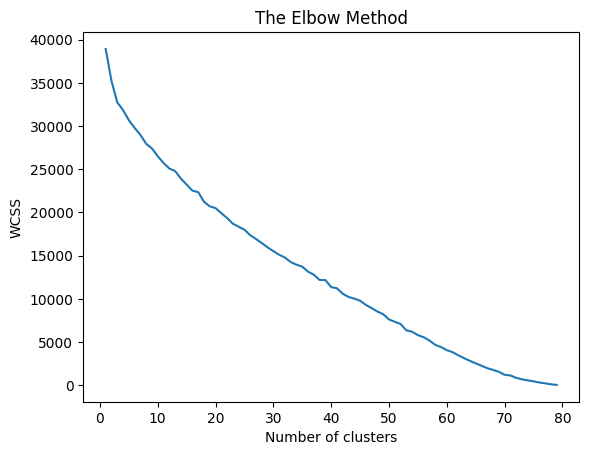

In [152]:
plt.plot(range(1, 80), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

####Training K Means clustering algorithm

In [177]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(features_selected)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [178]:
cluster_labels = kmeans.labels_

In [179]:
cluster_labels

array([0, 1, 0, 2, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0,
       2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1,
       0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

###Making final table

In [180]:
import pandas as pd

In [212]:
a = pd.DataFrame({'Image': img_name})

In [213]:
a['Cluster'] = cluster_labels

In [214]:
a

,Image,Cluster
0,man-gb4440ab53_640.jpg,0
1,mandu-g79128b0db_640.jpg,1
2,women-girl-gf81cdab46_640.jpg,0
3,puppy-ge9d742e37_640.jpg,2
4,beanie-g4c423e47b_640.jpg,0
...,...,...
75,selfie-g46d822e69_640.jpg,0
76,man-g6d33fb453_640.jpg,0
77,octopus-desktop-gab5dc2902_640.jpg,1
78,grandmother-g010adc60b_640.jpg,0


In [206]:
for i in range(3):
  print(i," - ",len(a[a['Cluster'] == i]))

0  -  41
1  -  20
2  -  19


In [215]:
a['Cluster_Name'] = a.Cluster.map({0:'Humans', 1:'Food', 2:'Dogs or Cats'})

In [216]:
a

,Image,Cluster,Cluster_Name
0,man-gb4440ab53_640.jpg,0,Humans
1,mandu-g79128b0db_640.jpg,1,Food
2,women-girl-gf81cdab46_640.jpg,0,Humans
3,puppy-ge9d742e37_640.jpg,2,Dogs or Cats
4,beanie-g4c423e47b_640.jpg,0,Humans
...,...,...,...
75,selfie-g46d822e69_640.jpg,0,Humans
76,man-g6d33fb453_640.jpg,0,Humans
77,octopus-desktop-gab5dc2902_640.jpg,1,Food
78,grandmother-g010adc60b_640.jpg,0,Humans
